In [2]:
# Import required libraries / packages
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.utilities import SQLDatabase
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate,ChatPromptTemplate
import sqlite3
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain import hub
from typing import Annotated, Literal
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage,ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
import os
from dotenv import load_dotenv
load_dotenv()

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3508: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

In [3]:
# Initialized the environment variables
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

##### Database Handling

In [3]:
class Database:
    def __init__(self,db_name):
        self.db_name = db_name
    
    
    def connect_to_db(self):
        conn = sqlite3.connect(f'{self.db_name}')
        return conn
    
    def create_table(self):
        conn = self.connect_to_db()
        cursor = conn.cursor()
        
        # Create candidates_table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS candidates_table (
            cand_id TEXT PRIMARY KEY,
            cand_name TEXT NOT NULL,
            cand_skills TEXT NOT NULL,
            cand_email TEXT NOT NULL,
            job_id TEXT NOT NULL
        )
        ''')
        print("Candidates table created")
        
        # Create job_posting_table
        cursor.execute('''
        CREATE TABLE IF NOT EXISTS job_posting_table (
            job_id TEXT PRIMARY KEY,
            job_name TEXT NOT NULL,
            job_location TEXT NOT NULL,
            job_description TEXT NOT NULL
        )
        ''')
        print("job postings table created")
        conn.commit()
        conn.close()

    def generate_id(self,prefix, table_name, column_name):
        conn = self.connect_to_db()
        cursor = conn.cursor()

        # Fetch the latest ID from the table
        cursor.execute(f"SELECT {column_name} FROM {table_name} ORDER BY {column_name} DESC LIMIT 1")
        last_id = cursor.fetchone()

        if last_id:
            # Extract the numeric part, increment it, and format with leading zeros
            numeric_part = int(last_id[0][len(prefix):])
            new_id = f"{prefix}{numeric_part + 1:05d}"
        else:
            # Start from 1 if no ID exists
            new_id = f"{prefix}00001"

        conn.close()
        return new_id
    
    def insert_candidate(self,cand_name, cand_skills, cand_email, job_id):
        conn = self.connect_to_db()
        cursor = conn.cursor()

        # Generate new candidate ID
        cand_id = self.generate_id("CAND", "candidates_table", "cand_id")

        # Insert data into candidates_table
        cursor.execute('''
        INSERT INTO candidates_table (cand_id, cand_name, cand_skills, cand_email, job_id)
        VALUES (?, ?, ?, ?, ?)
        ''', (cand_id, cand_name, cand_skills, cand_email, job_id))

        conn.commit()
        conn.close()

        return cand_id

    def insert_job(self,job_name, job_location, job_description):
        conn = self.connect_to_db()
        cursor = conn.cursor()

        # Generate new job ID
        job_id = self.generate_id("JOB", "job_posting_table", "job_id")

        # Insert data into job_posting_table
        cursor.execute('''
        INSERT INTO job_posting_table (job_id, job_name, job_location, job_description)
        VALUES (?, ?, ?, ?)
        ''', (job_id, job_name, job_location, job_description))

        conn.commit()
        conn.close()

        return job_id

In [4]:
db = Database(db_name='hrtech.db')
db.create_table()
job_id = db.insert_job("Software Engineer", "New York", "Develop and maintain software applications.")
cand_id = db.insert_candidate("John Doe", "Python, SQL, Machine Learning", "johndoe@example.com", job_id)
print(cand_id,job_id)

Candidates table created
job postings table created
CAND00008 JOB00009


In [5]:
job_1 = db.insert_job("Software Engineer", "New York", "Develop and maintain software applications.")
job_2 = db.insert_job("Data Scientist", "San Francisco", "Analyze large datasets and build predictive models.")
job_3 =db.insert_job("Frontend Developer", "Austin", "Create responsive user interfaces with React and CSS.")
job_4 =db.insert_job("Backend Developer", "Seattle", "Design and implement server-side logic with Node.js.")
job_5 =db.insert_job("Product Manager", "Boston", "Manage product lifecycle and collaborate with teams.")

In [6]:
db.insert_candidate("Alice Johnson", "Python, Machine Learning", "alice.johnson@example.com",job_1 )
db.insert_candidate("Bob Smith", "React, JavaScript, HTML", "bob.smith@example.com",job_1 )
db.insert_candidate("Charlie Brown", "Node.js, SQL", "charlie.brown@example.com", job_2)
db.insert_candidate("Diana Prince", "Agile, Product Management", "diana.prince@example.com",job_3 )
db.insert_candidate("Evan Davis", "Java, Spring Boot", "evan.davis@example.com", job_4)

'CAND00013'

##### Tool Creation

In [63]:
# Initializing the LLM
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
# llm=ChatGroq(model_name="Gemma2-9b-It")

In [64]:
db = SQLDatabase.from_uri("sqlite:///hrtech.db")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['candidates_table', 'job_posting_table']


In [65]:
# Initialized the toolkit and get the tools
toolkit = SQLDatabaseToolkit(db=db,llm=llm)
toolkit

SQLDatabaseToolkit(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002178CE90110>, llm=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002178FB0FCD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002178F9C8D50>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')))

In [66]:
sql_tools = toolkit.get_tools()

In [67]:
sql_tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002178CE90110>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002178CE90110>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000002178CE90110>),
 QuerySQLCheckerTool(description='Use this tool to 

In [68]:
# list out the tables present in databse
list_tables_tool = next((tool for tool in sql_tools if tool.name=='sql_db_list_tables'),None)

In [69]:
list_tables_tool.invoke("give me all jobs")

'candidates_table, job_posting_table'

In [70]:
# get the schema of mention table
get_schema_tool = next((tool for tool in sql_tools if tool.name=='sql_db_schema'),None)

In [71]:
# query sql database
query_database = next((tool for tool in sql_tools if tool.name=='sql_db_query'),None)

In [72]:
query_database.invoke("select * from candidates_table where cand_name='John Doe'")

"[('CAND00001', 'John Doe', 'Python, SQL, Machine Learning', 'johndoe@example.com', 'JOB00002'), ('CAND00002', 'John Doe', 'Python, SQL, Machine Learning', 'johndoe@example.com', 'JOB00003'), ('CAND00008', 'John Doe', 'Python, SQL, Machine Learning', 'johndoe@example.com', 'JOB00009')]"

In [73]:
# Defined the message state --> this state will pass to each node in the langgraph workflow
class State(TypedDict):
    messages : Annotated[list[AnyMessage],add_messages]

In [74]:
# Class to get the final_answer
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

In [75]:
def create_tool_node_with_fallback(tools: list):
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [76]:
@tool
def db_query_tool(query:str) -> str:
    
    """Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again."""
    print(f"Into the db query tool : {query}")
    result = db.run_no_throw(query)
    print(f"The result of db_query_tool : {result}")
    if not result:
        return "Error: Query failed, please rewrite the query and try again"
    else:
        return result
# testing
# db_query_tool.invoke("SELECT * FROM candidates_table")

In [77]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """
You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
  [("system", query_check_system), ("placeholder", "{messages}")]
)
llm_with_tools = llm.bind_tools([db_query_tool],tool_choice="required")
query_check_chain = (query_check_prompt | llm_with_tools)

In [78]:
# As soon as user query entered the workflow the list_tables tool gets called
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    print(f"From first_tool_call, state message : {state['messages']}")
    return {"messages": [AIMessage(content="",tool_calls=[{"name": "sql_db_list_tables","args": {},"id": "tool_abcd123",}],)]}

In [79]:
# list out the tables present in database
list_tables_tool = next((tool for tool in sql_tools if tool.name=='sql_db_list_tables'),None)

In [80]:
# now get the schema for the required table
get_schema_tool = next((tool for tool in sql_tools if tool.name=='sql_db_schema'),None)
get_model_schema = llm.bind_tools([get_schema_tool])

In [81]:
# now get the schema with error handling
get_schema_tool = next((tool for tool in sql_tools if tool.name=='sql_db_schema'),None)

In [94]:
# Generate the query based on the question and schema
query_gen_template = """
You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
"""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system",query_gen_template),("placeholder","{messages}")]
)
llm_with_tools = llm.bind_tools([SubmitFinalAnswer])
query_gen_chain = query_gen_prompt | llm_with_tools

def query_gen_node(state:State):
    print(f"Into the query generation tool : {state['messages']}")
    message = query_gen_chain.invoke(state)
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    ))
    else:
        tool_messages = []
    print(f"The result of query_gen_node : {[message]+tool_messages}")
    return {"messages":[message] + tool_messages}
    

In [95]:
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    print(f"Into the model check query tool : {state['messages'][-1]}")
    return {"messages": [query_check_chain.invoke({"messages": [state["messages"][-1]]})]}

In [96]:
# Router
def should_continue(state:State):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [97]:
# Define workflow
workflow = StateGraph(State)

# Add nodes in the graph
workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
workflow.add_node("get_model_schema",lambda state: {"messages": [get_model_schema.invoke(state["messages"])],},)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Add edges in the graph
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "get_model_schema")
workflow.add_edge("get_model_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")

workflow.add_conditional_edges("query_gen",should_continue,{"query_gen":"query_gen","correct_query":"correct_query",END:END})

workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

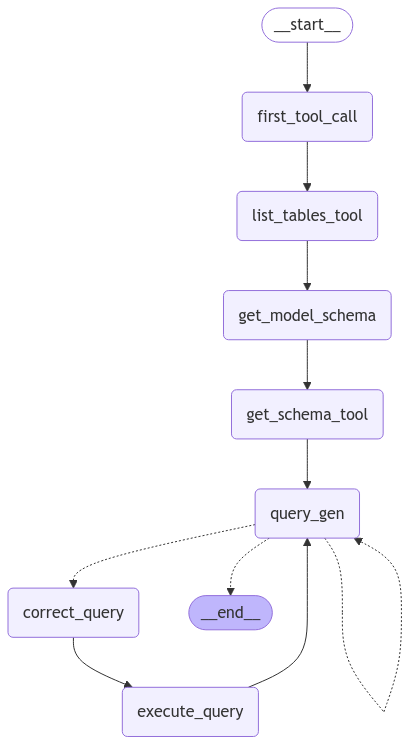

In [98]:
app

In [99]:
app.invoke({"messages":("user","give me the all job name present in the jobs table")})

From first_tool_call, state message : [HumanMessage(content='give me the all job name present in the jobs table', additional_kwargs={}, response_metadata={}, id='51bdc481-116c-40d3-bfb1-79fcaa38d144')]
Into the query generation tool : [HumanMessage(content='give me the all job name present in the jobs table', additional_kwargs={}, response_metadata={}, id='51bdc481-116c-40d3-bfb1-79fcaa38d144'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='370399dd-7bf7-4ea0-b4b7-f27da6b9f816', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='candidates_table, job_posting_table', name='sql_db_list_tables', id='4972a6ab-17c2-415c-adab-a936ac3eef76', tool_call_id='tool_abcd123'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4ex0', 'function': {'arguments': '{"table_names": "job_posting_table"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'compl

{'messages': [HumanMessage(content='give me the all job name present in the jobs table', additional_kwargs={}, response_metadata={}, id='51bdc481-116c-40d3-bfb1-79fcaa38d144'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='370399dd-7bf7-4ea0-b4b7-f27da6b9f816', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
  ToolMessage(content='candidates_table, job_posting_table', name='sql_db_list_tables', id='4972a6ab-17c2-415c-adab-a936ac3eef76', tool_call_id='tool_abcd123'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4ex0', 'function': {'arguments': '{"table_names": "job_posting_table"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 373, 'total_tokens': 393, 'completion_time': 0.072727273, 'prompt_time': 0.046987947, 'queue_time': 0.021310410000000002, 'total_time': 0.11971522}, 'model_name': 'llama-3.3-70b-ve